# 02 - Classification Modeling

## 1. Import Packages <a name="import"></a>

In [1]:
import os
import pprint as pp
import pickle

import copy

In [2]:
import pandas as pd
import numpy as np
import scipy

import bisect 
from scipy.stats import mstats 

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier, plot_importance

from sklearn.preprocessing import MinMaxScaler

In [20]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, ShuffleSplit

from sklearn.metrics import accuracy_score, precision_score, recall_score,\
                            make_scorer, fbeta_score, roc_curve, auc, \
                            roc_auc_score, precision_recall_curve, confusion_matrix

import shap

# load JS visualization code to notebook
shap.initjs()

## Table of Contents <a name="table"></a>
1. [Import Packages](#import)
2. [Import Data](#import_data)
3. [Standardization](#scale)
4. [Class Imbalance](#imb)
5. [Hyperparameter Tuning](#tune)
    1. [Imblearn Pipeline](#pipe)
    2. [Non-Pipeline Method](#no-pipe)
6. [Model Comparison](#compare)
7. [Feature Importance](#feature)
8. [Model Threshold](#threshold)
9. [SHAP for Model Interpretability](#shap)
10. [Save Model](#save)

## 2. Import Data <a name="import_data"></a>

In [14]:
file_dir = os.path.abspath('.')
csv_folder = 'data'

path = os.path.join(file_dir, csv_folder, 'ks2018.pkl')

ks2018 = pd.read_pickle(path)

ks2018.head()

,title_length,successful,min_45_backers,US,goal,project_duration,min_30_days,art,comics,crafts,...,fashion,film_video,food,games,journalism,music,photography,publishing,technology,theater
1,8,0,0,1,30000.0,59.80,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,0,0,1,45000.0,44.99,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7,0,0,1,5000.0,29.86,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,3,1,1,1,50000.0,34.43,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6,9,1,0,1,1000.0,19.23,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


If we look at the non-category-related data, we can see that no one feature offers data separability.

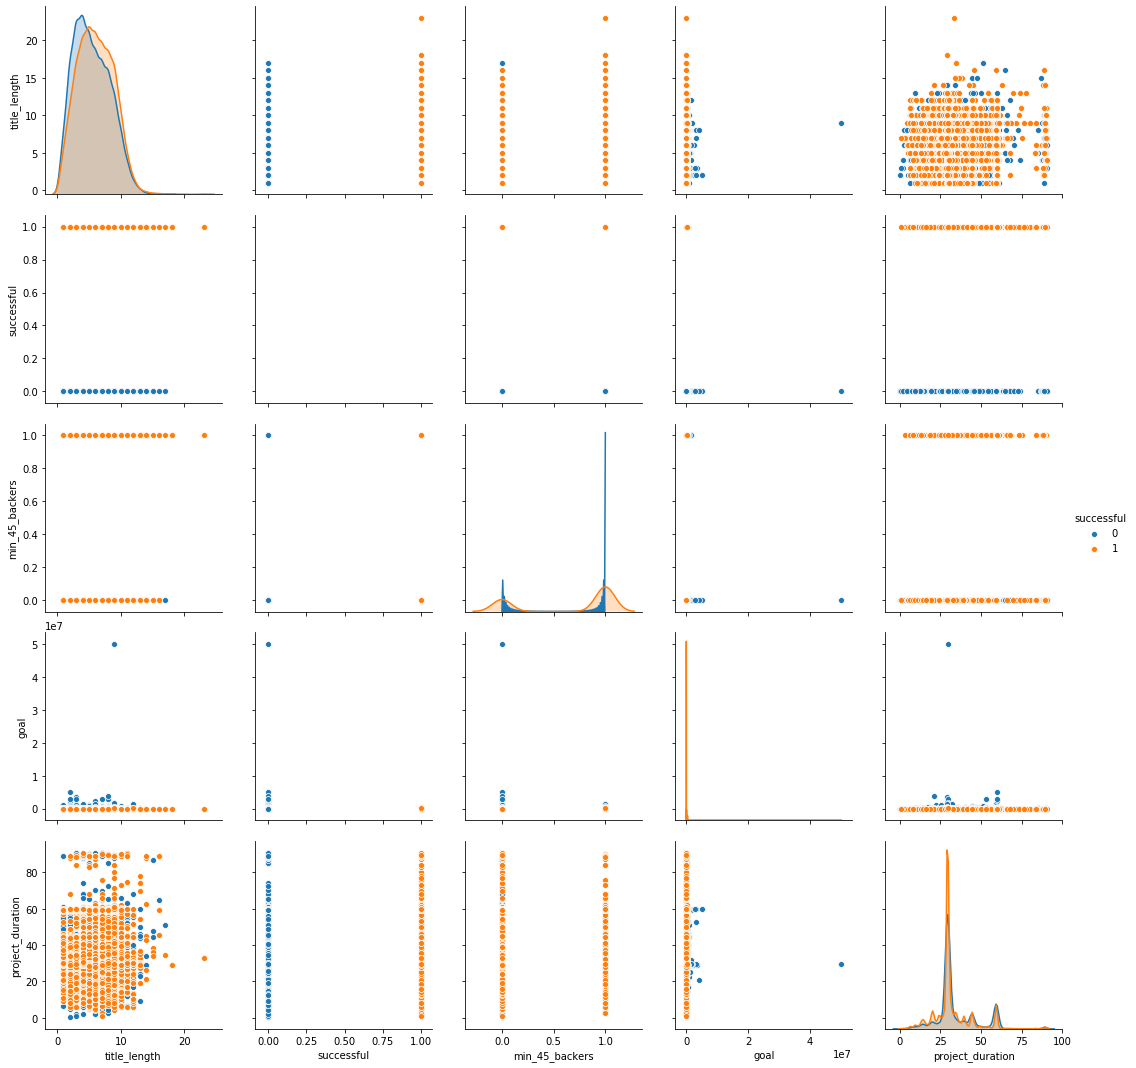

In [90]:
sample = ks2018.sample(10000)[['title_length', 'successful', 'min_45_backers', 
                               'goal', 'project_duration']]

pairplots = sns.pairplot(sample, height = 3, 
                         hue = 'successful');

Return to [Table of Contents](#table)

## 3. Standardization <a name="scale"></a>

The features are scaled for models like KNN that depend on a distance metric. <br>
We standardize 'title_length', 'goal', and 'project_duration' after creating a train and test set.

In [15]:
#split the data into the features and target
X, y = ks2018.drop('successful', axis = 1), ks2018['successful']

#sorting the columns
X = X.sort_index(axis=1)

#split the data into train and test, making sure to stratify to keep the same class ratios 
#shuffle in case the data is ordered chronologically
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42, 
                                                    stratify = y, 
                                                    shuffle = True)

X_train.head()

,US,art,comics,crafts,design,fashion,film_video,food,games,goal,journalism,min_30_days,min_45_backers,music,photography,project_duration,publishing,technology,theater,title_length
309765,0,0,0,1,0,0,0,0,0,4384.36,0,1,0,0,0,29.02,0,0,0,1
239624,1,0,0,0,0,0,1,0,0,2000.00,0,0,0,0,0,75.10,0,0,0,12
269014,1,0,0,0,0,0,0,0,1,2500.00,0,0,1,0,0,41.69,0,0,0,3
59799,0,0,0,0,0,0,1,0,0,1175.10,0,0,1,0,0,30.62,0,0,0,10
255356,1,0,0,0,0,0,1,0,0,600.00,0,1,0,0,0,29.08,0,0,0,3


In [16]:
#create a scaler, we use MinMaxScaler instead of StandardScaler 
#because some algorithms like KNN use euclidean distance
scaler = MinMaxScaler()

scaled_cols = ['title_length', 'goal', 'project_duration']

#drop the columns to be scaled to make reassigning easier
X_train, scaled_train_cols = X_train.drop(columns = scaled_cols), \
                                scaler.fit_transform(X_train[scaled_cols])

X_test, scaled_test_cols = X_test.drop(columns = scaled_cols), \
                                scaler.transform(X_test[scaled_cols])

#recreate the columns with the scaled values
#while making sure to reassign at the correct index
X_train[scaled_cols] = pd.DataFrame(scaled_train_cols,
                                    index = X_train.index,
                                    columns = scaled_cols)

X_test[scaled_cols] = pd.DataFrame(scaled_test_cols,
                                   index = X_test.index,
                                   columns = scaled_cols)

#sorting the columns to make it easier to compare against the original X_train
X_train, X_test = X_train.sort_index(axis = 1), X_test.sort_index(axis = 1)


X_train.head()

,US,art,comics,crafts,design,fashion,film_video,food,games,goal,journalism,min_30_days,min_45_backers,music,photography,project_duration,publishing,technology,theater,title_length
309765,0,0,0,1,0,0,0,0,0,0.000038,0,1,0,0,0,0.315051,0,0,0,0.00000
239624,1,0,0,0,0,0,1,0,0,0.000016,0,0,0,0,0,0.816520,0,0,0,0.34375
269014,1,0,0,0,0,0,0,0,1,0.000021,0,0,1,0,0,0.452933,0,0,0,0.06250
59799,0,0,0,0,0,0,1,0,0,0.000009,0,0,1,0,0,0.332463,0,0,0,0.28125
255356,1,0,0,0,0,0,1,0,0,0.000004,0,1,0,0,0,0.315704,0,0,0,0.06250


Producing pair plots for the entire dataset takes too long. <br>
Instead, we will only look at a small sample to see if any data offers any clear data separability. 

Return to [Table of Contents](#table)

## 4. Class Imbalance<a name="imb"></a>

Sampling while cross-validating class-imbalanced data can be tricky. <br>
Cross-validating will help us select the best parameters for the most consistent model. <br>
The data itself does not have a major class-imbalance, but balancing the data could improve the results. <br>

In [8]:
print('Number of Successful Kickstarter Campaigns: ' + str(y[y == 1].size))
print('Number of Failed Kickstarter Campaigns: ' + str(y[y == 0].size))

Number of Successful Kickstarter Campaigns: 129432
Number of Failed Kickstarter Campaigns: 157324


First, we used GridSearchCV to solely find the best sampling method. <br>
I used f2 score later, but I first tuned for ROC AUC since precision and recall are both tied to model thresholds. <br>
The model threshold value is not a true hyperparameter. <br>
I could achieve 100% precision or recall for any model by setting my threshold appropriately. <br>

Hyperparameter tuning while using different sampling methods is resource-intensive. <br>
However, sampling while cross-validating does not work with `n_jobs = -1`. <br>
This is the argument normally specified for faster performance on GridSearchCV. <br>
Multiple workers come into conflict while trying to sample and model training data, which is different for each fold. <br>
For now, it would be quicker to see which sampling method works best without cross-validation. <br>

In terms of models, K-Nearest Neighbors was chosen since it is a simple, straight-forward model to understand. <br>
Logistic Regression and Random Forest Classifier were chosen for model-interpretability via feature importance. <br>
XGBClassifier was chosen for its model performance and feature importance. <br>

In terms of sampling methods, no sampling method was chosen as the base sampling method of comparison. <br>
SMOTE and ADASYN were chosen for their ability to strategically create synthetic data. <br>
Unlike SMOTE, ADASYN should avoid creating synthetic data between inliers and outliers. <br>

In [290]:
#dictionary of classifiers
classifiers = {'KNN': KNeighborsClassifier(), 
               'LR': LogisticRegression(max_iter = 10000, solver ='saga'), 
               'RF': RandomForestClassifier(max_depth = 3), 
               'XGB': XGBClassifier(max_depth = 3)
              }

#dictionary of different sampling methods
samplers = {'sampling': [None, 
                         SMOTE(random_state = 42), 
                         ADASYN(random_state = 42)]
           }

#dictionary for storing results
results_dict = {}

#n_splits = 1 in ShuffleSplits allows us to avoid cross-validation
#cross-validating with n_jobs = -1 with sampling is not possible with pipeline
ss = ShuffleSplit(n_splits = 1)


for classifier_name, classifier in classifiers.items():
    
    #sampling is the first step, then classifying
    #the sampling method is None because it will be replaced later
    #by one of the sampling methods in samplers during GridSearchCV
    steps = [('sampling', None),
             (classifier_name, classifier)]
    
    #create pipeline object from steps
    model = Pipeline(steps)
    
    #instead of the usual hyperparameter tuning dictionary, 
    #a dictionary of different sampling methods is passed as param_grid
    #'sampling' in the pipeline is changed out 
    #with one of the samplings methods in samplers
    #scoring is changed to roc_auc score
    grid = GridSearchCV(model, samplers, cv = ss, 
                        n_jobs = -1, scoring = 'roc_auc', verbose = True)

    grid.fit(X_train, y_train)

    results = grid.cv_results_
    
    #we do not use mean_train_score since we have nothing to validation on
    scores = list(zip(results['params'], results['mean_test_score']))
    scores = sorted(scores, key = lambda x:x[1], reverse = True)

    results_dict[classifier_name] = scores

Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 14.0min finished


Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.2min finished


Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.2min finished


Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  8.3min finished


In this case, the classes are not very imbalanced and the data set is large. <br> 
No sampling method performed the best. <br>
No sampling method will be used, but I will still include 'sampling' in the pipeline as an option.

In [291]:
sampling_results = results_dict

pp.pprint(sampling_results)

{'KNN': [({'sampling': None}, 0.8338424854226312),
         ({'sampling': SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto')},
          0.8304923163133501),
         ({'sampling': ADASYN(n_jobs=None, n_neighbors=5, random_state=42, sampling_strategy='auto')},
          0.8248846199076953)],
 'LR': [({'sampling': SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto')},
         0.8601409979731616),
        ({'sampling': None}, 0.8601026346657631),
        ({'sampling': ADASYN(n_jobs=None, n_neighbors=5, random_state=42, sampling_strategy='auto')},
         0.8600516678067943)],
 'RF': [({'sampling': ADASYN(n_jobs=None, n_neighbors=5, random_state=42, sampling_strategy='auto')},
         0.8973292291629277),
        ({'sampling': None}, 0.8971616404196522),
        ({'sampling': SMOTE(k_neighbors=5, n_jobs=None, random_state=42, sampling_strategy='auto')},
         0.8915331403651064)],
 'XGB': [({'sampling': None}, 0.9131457088753299),
  

Return to [Table of Contents](#table)

## 5. Hyperparameter Tuning <a name="tune"></a>

After selecting the best sampling method i.e. none, we hyperparameter tune the models before generating an roc-auc curve plot. <br> 
Hence, the metric used in the previous section and this section is roc-auc score. <br>
Note, roc-auc score currently only works for binary classifiers.

### 5A. Imblearn Pipeline <a name = 'pipe'>


I set `return train score = True` in `GridSearchCV` to study the train and test sets to check for underfitting and overfitting.

In [ ]:
classifiers = {'KNN': KNeighborsClassifier(), 
               'LR': LogisticRegression(max_iter = 10000, solver ='saga'), 
               'RF': RandomForestClassifier(), 
               'XGB': XGBClassifier()
              }

param_dict = {'KNN': {'KNN__n_neighbors': [3, 5, 7]}, 
              'LR': {'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
              'RF': {'RF__n_estimators': [100, 250, 500, 1000], 
                     'RF__max_depth': [3, 4, 5]},
              'XGB': {'XGB__n_estimators': [100, 250, 500, 1000], 
                      'XGB__max_depth': [3, 4, 5], 
                      'XGB__learning_rate': [0.001, 0.01, 0.1]}
             }

results_dict = {}


#we use the stratify version of k-fold to keep the class imbalance ratio
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for classifier_name, classifier in classifiers.items():
    
    #sampling is the first step, then classifying
    #'sampling' is None because no sampling was best
    #if 'sampling' is not None, change n_jobs in GridSearchCV to 1
    steps = [('sampling', None),
             (classifier_name, classifier)]
    
    model = Pipeline(steps)
    
    #fetch the parameters from param_dict
    params = param_dict[classifier_name]
    
    #scoring is changed to roc_auc score
    #we specify return_train_score = True to 
    #compare train and test to check for overfitting
    #if 'sampling' is not None, change n_jobs in GridSearchCV to 1
    #this is to avoid conflict among the workers 
    #due to sampling and modeling the training set, which changes across folds
    grid = GridSearchCV(model, params, cv = kf, return_train_score = True,
                        n_jobs = -1, scoring = 'roc_auc', verbose = True)

    grid.fit(X_train, y_train)

    results = grid.cv_results_
    
    scores = list(zip(results['params'], results['mean_train_score'], results['mean_test_score']))
    scores = sorted(scores, key = lambda x:x[2], reverse = True)

    results_dict[classifier_name] = scores

In terms of results, KNN performed the best on the training set. <br>
However, a comparison between the train and test sets reveals that KNN overfit on train. <br>
In terms of test performance, the model ranking is XGBClassifier, Random Forest, Logistic Regression, and KNN.<br>
XGBClassifier was the best model and KNN was the worst. <br>

In terms of parameters:
- KNN took the longest to train and performed the best with `n_neighbors = 7`
- Logistic regression was just barely the fastest model to train and performed the best with `C = 1000`
- Random forest did the best with `max_depth = 5` with `n_estimators = 500` being sufficient
- XGBClassifier with `learning_rate = 0.1` and `max_depth = 3` with `n_estimators = 500` being sufficient 

In [247]:
pp.pprint(results_dict)

{'KNN': [({'KNN__n_neighbors': 7}, 0.9118497298746748, 0.8441306918939944),
         ({'KNN__n_neighbors': 5}, 0.9234555154537789, 0.8349149493901447),
         ({'KNN__n_neighbors': 3}, 0.9445827506542599, 0.8142361863180974)],
 'LR': [({'LR__C': 1000}, 0.8748967595577695, 0.8748425774202108),
        ({'LR__C': 100}, 0.8651369705724985, 0.8650818667938032),
        ({'LR__C': 10}, 0.8604070076870325, 0.8603528413417012),
        ({'LR__C': 1}, 0.8593007011732589, 0.8592466258874621),
        ({'LR__C': 0.1}, 0.8590157615599588, 0.8589622806755468),
        ({'LR__C': 0.01}, 0.8575872815909928, 0.8575392659037346),
        ({'LR__C': 0.001}, 0.8542992494149416, 0.8542592451134837)],
 'RF': [({'RF__max_depth': 5, 'RF__n_estimators': 1000},
         0.9068181941437061,
         0.9064027618461878),
        ({'RF__max_depth': 5, 'RF__n_estimators': 500},
         0.9067594128530402,
         0.9063145611586612),
        ({'RF__max_depth': 5, 'RF__n_estimators': 250},
         0.906269364

Return to [Table of Contents](#table)

### 5B. Non-Pipeline Method <a name="no-pipe"></a>

This is a completely optional hyperparameter tuning section. <br>
While pipeline methods simplify the workflow, there are some caveats. <br>

As previously mentioned, `n_jobs = -1` does not work when the pipeline contains both sampling and modeling. <br>
The workers conflict with each other in trying to simulatenously sample and model the training set, which changes for each fold. <br>
In addition, if the classes are heavily imbalanced, sampling will takes a long time without `n_jobs = -1`. <br> 
To make matters worse, sampling in a pipeline is done nk times for each n variation of a model where k number of K folds. <br> 

The custom code in this section attempts to address these inefficiencies. <br> 
Each model is tested on the exact same folds. <br>
This means that for each sampling method, sampling is done only once per fold for a total of k times. <br>
Sampling and modeling occur relatively separate, so `n_jobs = -1` can be used for both. <br>
In addition, I can see the results for different metrics instead of one. <br> 
This helps in cases like the f1 score where either precision and recall are affecting the results. <br>

The disadvantage is that the code is much longer than using a pipeline. <br>
I also do not recommend including more than one sampling method at a time. <br>
It is is better to find the optimal sampling method first, though that may vary per model.

In [293]:
def create_results_dict(samplers, classifiers, params, scores):
    """
        Helper function that creates a dictionary that stores metric performance
        scores for each classifier, given a combination of sampling methods
        and hyperparameters 
        
        :param samplers: a dictionary of sampling methods
        :param classifiers: a dictionary of classifiers
        :param params: a dictionary for hyperparameter tuning the classifiers
        :param scores: a dictionary of metrics
        
        :returns result_dict: a dictionary that stores metric performance scores of each classifier,
                              given a combination of sampling methods and hyperparameters
    """

    #create an empty dictionary for storing results
    results_dict = {}

    for classifier_name in classifiers.keys():
        results_dict[classifier_name] = {}

        for sampler_name in samplers.keys():

            grid = ParameterGrid(param_dict[classifier_name])

            #create placeholder dictionary for params of each classifier


            for params in grid:
                #the sampling method is considered a parameter
                #thus, it is used also included as parameters
                param_str = 'sampling_method: %s, ' %sampler_name + \
                                str(params).replace('{','').replace('}','').replace("'",'') 

                results_dict[classifier_name][param_str] = {'train': copy.deepcopy(scores), 
                                                            'val': copy.deepcopy(scores)}
    
    return results_dict

In [256]:
def make_train_val(X, y_true, train_ind, val_ind, sampler):
    """
        Helper function that creates training and test data from indices
        produced by K-Fold splitting
        
        :param X: data containing features
        :param y_true: data containing actual class labels

        :param train_ind: list of indices that designate training data
        :param val_ind: list of indices that designate validation data
        
        :param sampler: sampling method function e.g. SMOTE
        
        :returns X_tr: training data containing features
        :returns y_tr: training data containing actual class labels
        
        :returns X_val: validation data containing features
        :returns y_val: validation data containing actual class labels
    """
    
    #train and validation set are assigned
    #based on the indices provided by splits
    X_tr, y_tr = X[train_ind], y_true[train_ind]
    X_val, y_val = X[val_ind], y_true[val_ind]

    #if the sampler is None, we do not fit
    if sampler:
        #set n_jobs = -1 for faster fitting
        sampler = sampler.set_params(random_state = 42, n_jobs = -1)

        #reassign X_tr and y_tr to the new sampled i.e. balanced data
        X_tr, y_tr = sampler.fit_sample(X_tr, y_tr)
    
    return X_tr, y_tr, X_val, y_val

In [257]:
def scorer(X, y_true, classifier, scores, beta = 1):
    """
        Helper function that creates a dictionary that stores metric performance
        scores for each classifier
        
        :param X: data containing features
        :param y_true: data containing actual class labels

        :param classifier: classification model
        
        :param scores: dictionary of desired scores
  
        :param beta: beta is solely for tuning fbeta, default value 1 for f1
        
        :returns score_dict: a dictionary that stores metric performance scores of each classifier
    """
    
    score_dict = {}
    
    #make predictions for X
    y_pred = classifier.predict(X)
      
    if 'accuracy' in scores.keys():
        score_dict['accuracy'] = accuracy_score(y_true, y_pred)
    
    if 'precision' in scores.keys():
        score_dict['precision'] = precision_score(y_true, y_pred)
    
    if 'recall' in scores.keys():
        score_dict['recall'] = recall_score(y_true, y_pred)

    if 'fbeta' in scores.keys():
        score_dict['fbeta'] = fbeta_score(y_true, y_pred, beta)
        
    if 'roc_auc' in scores.keys():
        #predict probabilities for train and val set
        #some classification models do not have predict_proba
        #in which case, a score of NaN is returned
        try:
            y_proba = classifier.predict_proba(X)[:,1]
            score_dict['roc_auc'] = roc_auc_score(y_true, y_proba)

        except:
            score_dict['roc_auc'] = float('Nan')
    
    
    return score_dict

In [ ]:
def cross_val_optimize(X, y_true, samplers, classifiers, params, scores, results_dict, beta = 1, kf):
    """
        Main function for performing model optimization while cross-validating
        
        :param X: data containing features
        :param y_true: data containing actual class labels
        
        :param samplers: a dictionary of sampling methods
        :param classifiers: a dictionary of classifiers
        :param params: a dictionary for hyperparameter tuning the classifiers
        :param scores: a dictionary of metrics
        :param results_dict: a nested dictionary of scores produced by create_results_dict

        :param beta: beta is solely for tuning fbeta, default value 1 for f1
        :param kf: a StratifiedKFold object, or equivalent
        
        :returns results_dict: a dictionary that stores metric performance scores of each classifier
    """
    
    #we need to convert X_train and y_train to np.arrays for indexing purposes
    X_train_copy, y_train_copy = np.array(X), np.array(y_true) 


    for sampler_name, sampler in samplers.items():

        print('Current Sampling Method: %s' %sampler_name)

        #create splits using k folds
        splits = kf.split(X_train_copy, y_train_copy)

        fold_num = 1

        for train_ind, val_ind in splits:
            print('\tCurrent Fold: %s' %str(fold_num))

            #make training and validation data
            X_tr, y_tr, X_val, y_val = make_train_val(X_train_copy, y_train_copy, 
                                                      train_ind, val_ind, sampler)

            #we evaluate each classification model on each train and test fold
            for classifier_name, classifier in classifiers.items():

                print('\t\tCurrent Classification Model: %s' %classifier_name)

                #use ParamterGrid to create all possible combinations of parameters
                grid = ParameterGrid(param_dict[classifier_name])

                for params in grid:
                    #assign the parameters, including n_jobs = -1 for faster performance
                    classifier = classifier.set_params(**params, n_jobs = -1)

                    #fit on the train set
                    classifier.fit(X_tr, y_tr)

                    #fetch scores for train and test 
                    train_scores = scorer(X_tr, y_tr, classifier, scores, beta = 2)

                    val_scores = scorer(X_val, y_val, classifier, scores, beta = 2)

                    #update results_dict with the train and test scores on current fold
                    for score in scores.keys():
                        train_score = train_scores[score]
                        val_score = val_scores[score]

                        param_str = 'sampling_method: %s, ' %sampler_name + \
                                        str(params).replace('{','').replace('}','').replace("'",'') 

                        #save each score to results_dict
                        results_dict[classifier_name][param_str]['train'][score].append(train_score)
                        results_dict[classifier_name][param_str]['val'][score].append(val_score)

            fold_num += 1
    
    return results_dict

In [288]:
def create_mean_scores(samplers, classifiers, params, scores, results_dict):
    """
        Helper function that creates a dictionary from results_dict
        that stores mean metric performance scores for each classifier
        
        :param samplers: a dictionary of sampling methods
        :param classifiers: a dictionary of classifiers
        :param params: a dictionary for hyperparameter tuning the classifiers
        :param scores: a dictionary of metrics
        :param results_dict: a nested dictionary of scores produced by create_results_dict
        
        :returns mean_scores: a dictionary that stores mean metric performance score of each classifier,
                              given a combination of sampling methods and hyperparameters
    """

    mean_scores = {}

    for classifier_name in classifiers.keys():
        #create placeholder dictionary for ach classifier
        mean_scores[classifier_name] = {}

        for sampler_name in samplers.keys():
            
            grid = ParameterGrid(param_dict[classifier_name])

            for params in grid:
                #the sampling method is considered a parameter
                #thus, it is used also included as parameters
                param_str = 'sampling_method: %s, ' %sampler_name + \
                                str(params).replace('{','').replace('}','').replace("'",'') 

                #create placeholder dictionary for params of each classifier
                mean_scores[classifier_name][param_str] = copy.deepcopy(scores)

                for score in scores.keys():
                    train_scores = results_dict[classifier_name][param_str]['train'][score]
                    val_scores = results_dict[classifier_name][param_str]['val'][score]
                    
                    #if NaN appears for roc_auc, then the mean will be NaN
                    if float('Nan') in train_scores:
                        mean_scores[classifier_name][param_str][score] = {'train': float('Nan'), 
                                                                          'val': float('Nan')}
                        continue
                    
                    mean_train_score = sum(train_scores)/len(train_scores)
                    mean_val_score = sum(val_scores)/len(val_scores)

                    mean_scores[classifier_name][param_str][score] = {'train': mean_train_score, 
                                                                      'val': mean_val_score}
                    
    return mean_scores

In [294]:
#create scores that will be stored
scores = {'accuracy': [],
          'precision': [],
          'recall': [], 
          'fbeta': [], 
          'roc_auc': []
         }


#dictionary of sampling methods
#we use None as a base model of comparison
samplers = {'None': None, 
            'SMOTE': SMOTE()
           }

#dictionary of classification models
#KNN was chosen as the base model of comparison
#logstitic regression and random forest were chosen 
#for their model interpetibility via feature importance
#XGB was chosen for feature importance and model performance
classifiers = {'KNN': KNeighborsClassifier(), 
               'LR': LogisticRegression(max_iter = 10000, solver ='saga'), 
               'RF': RandomForestClassifier(), 
               'XGB': XGBClassifier(random_state = 42)
              }

#dictionary of hyperparameters tuning each classification model
param_dict = {'KNN': {'n_neighbors': [3, 5, 7]},
              'LR': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
              'RF': {'n_estimators': [100, 250, 500, 1000], 
                     'max_depth': [3, 4, 5]},
              'XGB': {'n_estimators': [100, 250, 500, 1000], 
                      'max_depth': [3, 4, 5], 
                      'learning_rate': [0.001, 0.01, 0.1]}
             }


#create dictionary to store results
results_dict = create_results_dict(samplers, classifiers, param_dict, scores)


#using StratifiedKFold to produce folds 
#while maintaining ratio of class imbalance
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)


#call main function cross_val_optimize to fill in results_dict
results_dict = cross_val_optimize(X_train, y_train, samplers, classifiers, 
                                  params, scores, results_dict, beta = 1, kf):

Current Sampling Method: None
	Current Fold: 1
		Current Classification Model: KNN
		Current Classification Model: LR
		Current Classification Model: RF
		Current Classification Model: XGB
	Current Fold: 2
		Current Classification Model: KNN
		Current Classification Model: LR
		Current Classification Model: RF
		Current Classification Model: XGB
	Current Fold: 3
		Current Classification Model: KNN
		Current Classification Model: LR
		Current Classification Model: RF
		Current Classification Model: XGB
	Current Fold: 4
		Current Classification Model: KNN
		Current Classification Model: LR
		Current Classification Model: RF
		Current Classification Model: XGB
	Current Fold: 5
		Current Classification Model: KNN
		Current Classification Model: LR
		Current Classification Model: RF
		Current Classification Model: XGB
Current Sampling Method: SMOTE
	Current Fold: 1
		Current Classification Model: KNN
		Current Classification Model: LR
		Current Classification Model: RF
		Current Classificat

This took several hours to run, but the pipeline would have taken more than a day. <br>
Again, it is better to not test muliple sampling methods and tune multiple hyperparameters at the same time.

In [295]:
mean_scores = create_mean_scores(samplers, classifiers, params, scores, results_dict)
pp.pprint(mean_scores)

{'KNN': {'sampling_method: None, n_neighbors: 3': {'accuracy': {'train': 0.8659352066884061,
                                                                'val': 0.7664208294468308},
                                                   'fbeta': {'train': 0.8481331127273304,
                                                             'val': 0.7378532105495459},
                                                   'precision': {'train': 0.8550975819874177,
                                                                 'val': 0.7436022927569574},
                                                   'recall': {'train': 0.8464097735284175,
                                                              'val': 0.7364334347385195},
                                                   'roc_auc': {'train': 0.9445827506542599,
                                                               'val': 0.8142361863180974}},
         'sampling_method: None, n_neighbors: 5': {'accuracy': {'train': 0.838738645

                                                                                          'roc_auc': {'train': 0.9161564868039879,
                                                                                                      'val': 0.9154757013269623}},
         'sampling_method: None, learning_rate: 0.01, max_depth: 3, n_estimators: 250': {'accuracy': {'train': 0.8190757373734519,
                                                                                                      'val': 0.8188436214970813},
                                                                                         'fbeta': {'train': 0.7819233753850219,
                                                                                                   'val': 0.7817274061923919},
                                                                                         'precision': {'train': 0.8158306498372614,
                                                                                          

                                                                                          'precision': {'train': 0.8357271468971874,
                                                                                                        'val': 0.7874214076183383},
                                                                                          'recall': {'train': 0.8762821906549835,
                                                                                                     'val': 0.8482592109710755},
                                                                                          'roc_auc': {'train': 0.9330508493475345,
                                                                                                      'val': 0.9153779139479946}},
         'sampling_method: SMOTE, learning_rate: 0.1, max_depth: 5, n_estimators: 250': {'accuracy': {'train': 0.8407801609580512,
                                                                                   

Return to [Table of Contents](#table)

## 6. Model Comparison <a name="compare"></a>

After optimizing the models for roc-auc score, we can more accurately compare them against each other.

In terms of parameters:
- KNN with `n_neighbors = 7`
- Logistic regression with `C = 1000`
- Random forest with `max_depth = 5` with `n_estimators = 500` being sufficient
- XGBClassifier with `learning_rate = 0.1` and `max_depth = 3` with `n_estimators = 500` being sufficient 

In [126]:
def plot_roc_curves(classifiers, X_train, y_train, X_test, y_test, sampler = None):
    """
        Function for plotting roc curves of classifiers for comparison
        
        :param classifiers: dictionary of classifiers
        :param sampler: sampling method to use e.g. SMOTE
        
        :returns fpr: an array of false positive rate values from roc_curve
        :returns tpr: an array of true positive rate values from roc_curve
        :returns thresholds: an array of threshold values from roc_curve
        :returns roc_auc: roc_auc scores for each classifier in classifiers
    """

    fpr, tpr, thresholds = {}, {}, {}
    roc_auc = {}


    for classifier_name, classifier in classifiers.items():

        #set n_jobs = -1 for faster performance
        classifier = classifier.set_params(n_jobs = -1)

        if sampler:
            sampler.set_params(random_state = 42, n_jobs = -1)

        steps = [('sampling', sampler),
                 (classifier_name, classifier)]

        model = Pipeline(steps)

        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_test)[:,1]

        fpr[classifier_name], tpr[classifier_name], thresholds[classifier_name] = roc_curve(y_test, y_proba)

        roc_auc[classifier_name] = round(auc(fpr[classifier_name], tpr[classifier_name]), 3)

        print(classifier_name + ' roc_auc score: ' + str(roc_auc[classifier_name]))


    plt.figure(figsize=(8, 8))

    for classifier_name, classifier in classifiers.items():
        sns.lineplot(fpr[classifier_name], tpr[classifier_name], err_style = None);

    midline_points = np.arange(0, 1.05, 0.05) 

    plt.plot(midline_points, midline_points, linestyle ='--', color = 'black');
    plt.title("ROC Curves for Different Classification Models", y =1.05, fontsize = 16);
    plt.xlabel('FPR', fontsize = 12, x = 1.05);
    plt.ylabel('TPR', fontsize = 12, rotation =0, y = 1.05);
    plt.legend(list(zip(classifiers.keys(), roc_auc.values())));

    return fpr, tpr, thresholds, roc_auc

I chose to include an ensemble as well. 

KNN roc_auc score: 0.847
LR roc_auc score: 0.878
RF roc_auc score: 0.905
XGB roc_auc score: 0.917
Ensemble roc_auc score: 0.913


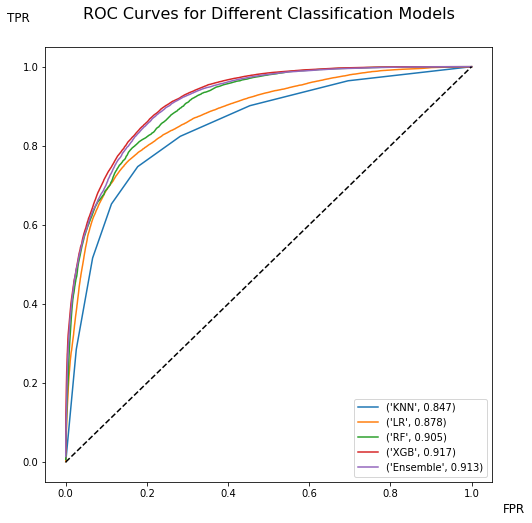

In [39]:
lr = LogisticRegression(C = 1000, max_iter = 10000, random_state = 42,
                        solver ='saga', class_weight = 'balanced')

rf = RandomForestClassifier(max_depth = 5, n_estimators = 500, class_weight = 'balanced')

xgb = XGBClassifier(random_state = 42, learning_rate = 0.1, max_depth = 3, 
                    n_estimators = 500, class_weight = 'balanced')

classifiers = {'KNN': KNeighborsClassifier(n_neighbors = 7), 
               'LR': lr, 
               'RF': rf, 
               'XGB': xgb,
               'Ensemble': VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
                                            voting='soft', weights=[1, 1, 1])
              }

fpr, tpr, thresholds, roc_auc = plot_roc_curves(classifiers,  
                                                X_train, y_train, X_test, y_test)

The model with the best roc-auc score was XGBClassifier. <br>
However, I chose to use logistic regression for a few reasons:
- in terms of run-time complexity, it is the quickest for making predictions
- feature importance is directional unlike tree-based methods
- for this specific project, we are more interested in TPR over FPR and the models perform similarly

I could use methods like SHAP to get directional feature importance. <br>
SHAP is based on specially-weighted local linear regression though. <br>
In some cases, the feature importance from tree-based methods and linear models can differ.

Return to [Table of Contents](#table)

## 7. Feature Importance <a name="feature"></a>

After the initial model comparison, it is possible to further improve each model by removing features. <br>
Removing features reduces model complexity, which in turn reduces over-fitting. <br>
We remove features with low feature importance scores. <br>

Here is the feature importance from the best performing model, XGBClassifier. <br>

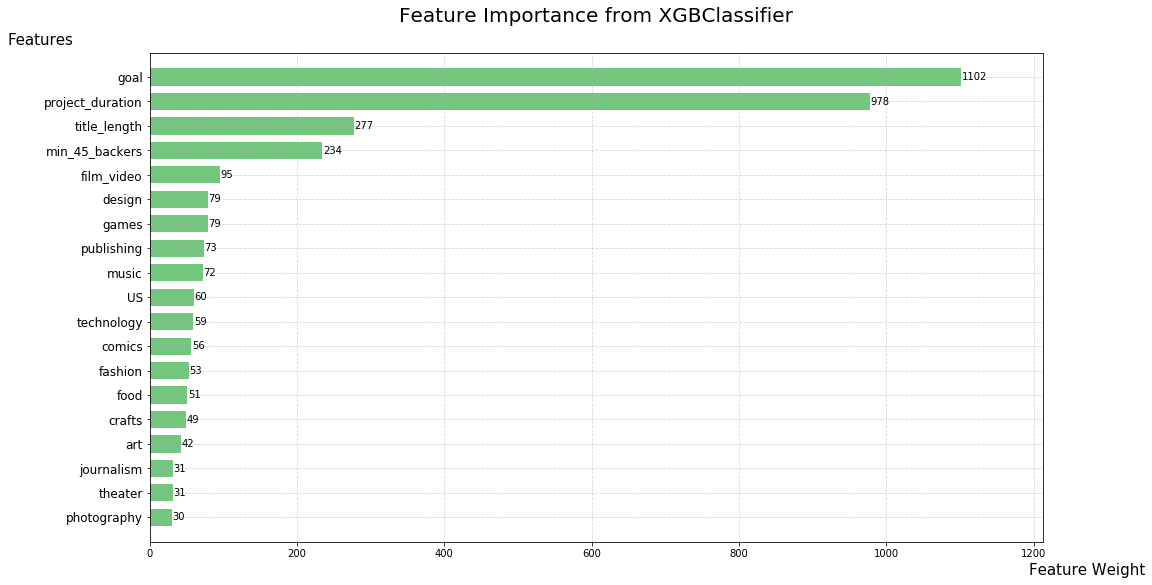

In [40]:
fig, ax = plt.subplots(figsize=(16,9));
plot_importance(xgb, height = 0.7, ax = ax, importance_type = 'weight', 
                color = sns.xkcd_rgb["medium green"], alpha = 0.7);

plt.xlabel(xlabel = 'Feature Weight', size = 15, x = 1.05);
plt.ylabel(ylabel = 'Features', size = 15, rotation = 0, y = 1.01);
plt.title('Feature Importance from XGBClassifier', fontsize=20, y = 1.05);
plt.yticks(fontsize=12);
plt.grid(linestyle='--', alpha=0.5)

Here is the feature importance from logistic regression, the model I selected. <br>

In [15]:
lr_feature_df = pd.DataFrame.from_dict({'Features': X.columns, 
                                        'Coefs': lr.coef_[0]})

lr_feature_df['Colors'] = lr_feature_df['Coefs'].apply(lambda coef: 'red' 
                                                          if coef < 0 else sns.xkcd_rgb["medium green"])

lr_feature_df = lr_feature_df.sort_values('Coefs', ascending = True).reset_index(drop = True)

lr_feature_df

,Features,Coefs,Colors
0,goal,-1451.389151,red
1,project_duration,-2.784093,red
2,technology,-2.193712,red
3,food,-2.045127,red
4,games,-2.020319,red
5,design,-1.954761,red
6,fashion,-1.810702,red
7,journalism,-1.714059,red
8,crafts,-1.624900,red
9,publishing,-1.500023,red


The beta coefficient of 'goal' was too large i.e. -1451.39. <br>
I plotted every beta coefficient except for 'goal' to better compare the other features. <br>
It is interesting to note that projects that campaign over 30 days do increase the chance of failure. <br>
This insight about project duration is consistent with what Kickstarter claimed. 

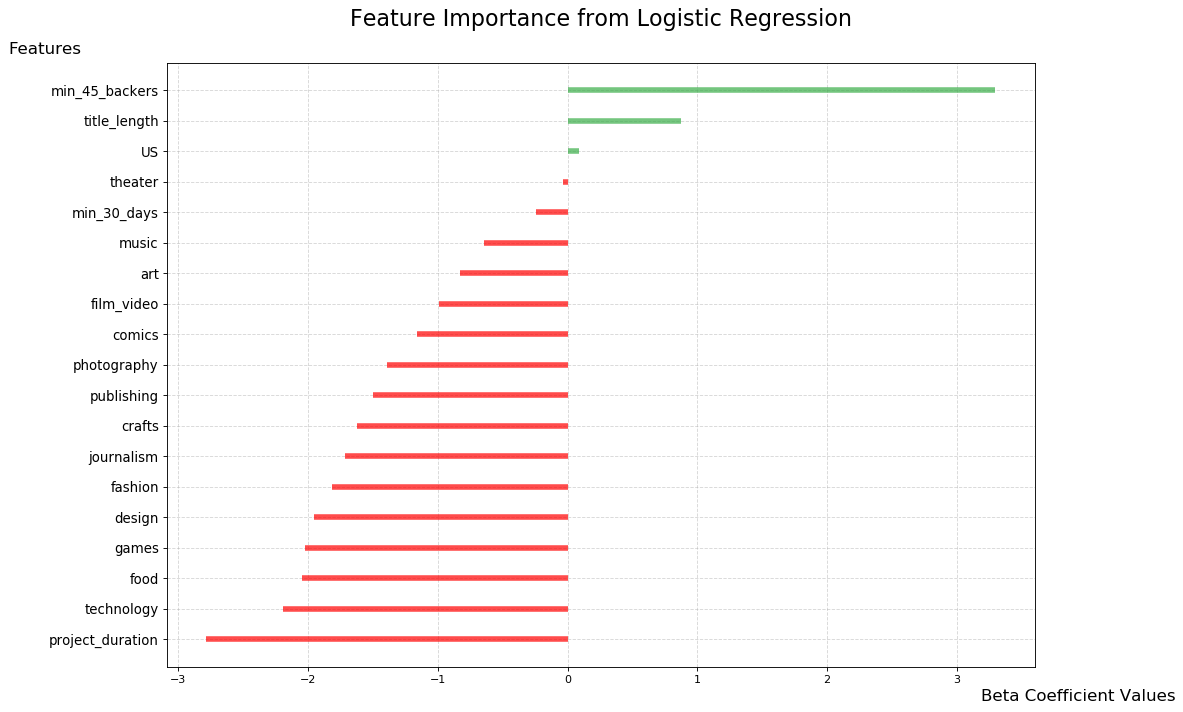

In [16]:
goal_index = lr_feature_df[lr_feature_df['Features'] == 'goal'].index
lr_feature_df = lr_feature_df.drop(index = goal_index)

plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y = lr_feature_df.index, xmin = 0, xmax = lr_feature_df['Coefs'], 
           color=  lr_feature_df['Colors'], alpha=0.7, linewidth=5)

plt.xlabel(xlabel = 'Beta Coefficient Values', size = 15, x = 1.05)
plt.ylabel(ylabel = 'Features', size = 15, rotation = 0, y = 1.01)

plt.yticks(lr_feature_df.index, lr_feature_df['Features'], fontsize=12)
plt.title('Feature Importance from Logistic Regression', fontsize=20, y = 1.05)
plt.grid(linestyle='--', alpha=0.5)

plt.savefig("./img/Feature Importance from Logistic Regression.png")

Interestingly enough, the feature importance from logistic regression and XGBClassifier are different. <br>
Even if we use SHAP to visualize the feature importance from logistic regression as a bar chart, they still differ. <br>
Differences in feature importance are tied to model performance and model non-linearity. <br>

Even between different versions of the same model, feature importance might be different. <br>
It is ideal to use the feature importance from the best performing model. <br>
In this case though, logistic regression and XGBClassifier performed similarly well. <br>

The most likely cause is model non-linearity. <br>
Logistic regression is a linear method while tree-based models are non-linear. <br>
Thus, feature importance is dependent on the model selected, and in turn, the function being fitted.

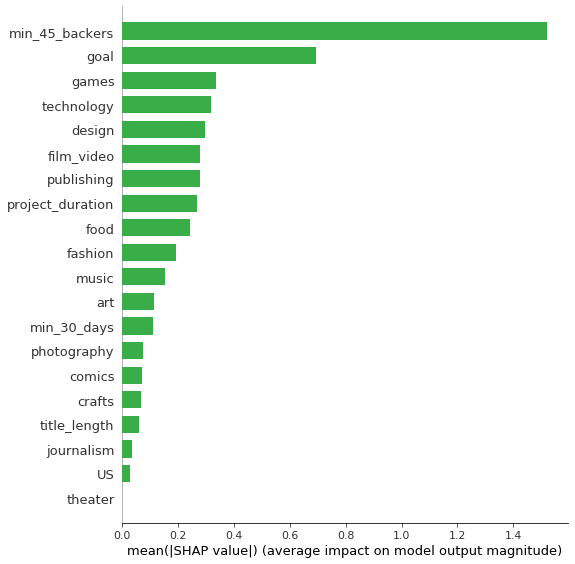

In [17]:
explainer = shap.LinearExplainer(lr, X_train, feature_perturbation = "interventional")

shap_values = explainer.shap_values(X_test)

#a dense array is needed for SHAP
X_test_dense = scipy.sparse.csr_matrix(X_test.values).toarray()

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values, X_test_dense, feature_names=X.columns, plot_type = 'bar', 
                  color = sns.xkcd_rgb["medium green"], alpha = 0.7)

Dropping most of the main categories, 'US', and 'min_30_days' did not significantly decrease model performance. <br>
Most projects are based in the 'US' while 'min_30_days' is already represented by 'project_duration'. <br>
As for the categories, it is likely that people browse by categories when searching for projects to support. <br>
Thus, category plays less of a role in terms of campaign outcome. <br>
The only exceptions are categories like games that inherently require more funding to produce. 

KNN roc_auc score: 0.853
LR roc_auc score: 0.871
RF roc_auc score: 0.905
XGB roc_auc score: 0.913
Ensemble roc_auc score: 0.909


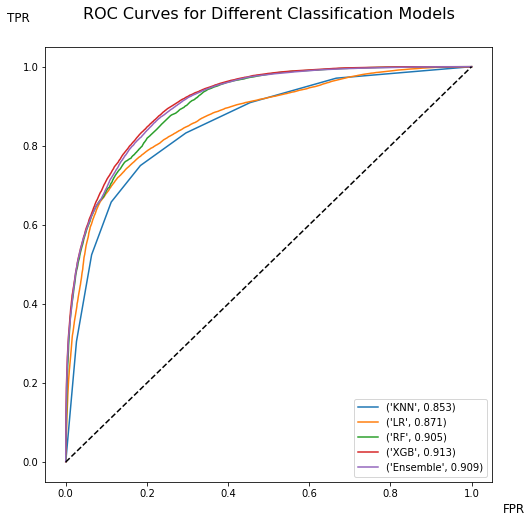

In [41]:
dropped_cols = ['theater', 'US', 'min_30_days', 'journalism', 
                'crafts', 'comics', 'photography', 'art', 
                'music', 'fashion', 'food', 'publishing']

lr = LogisticRegression(C = 1000, max_iter = 10000, random_state = 42,
                        solver ='saga', class_weight = 'balanced')

rf = RandomForestClassifier(max_depth = 5, n_estimators = 500, class_weight = 'balanced')

xgb = XGBClassifier(random_state = 42, learning_rate = 0.1, max_depth = 3, 
                    n_estimators = 500, class_weight = 'balanced')

classifiers = {'KNN': KNeighborsClassifier(n_neighbors = 7), 
               'LR': lr, 
               'RF': rf, 
               'XGB': xgb,
               'Ensemble': VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('xgb', xgb)],
                                            voting='soft', weights=[1, 1, 1])
              }

fpr, tpr, thresholds, roc_auc = plot_roc_curves(classifiers,  
                                                X_train.drop(columns = dropped_cols), 
                                                y_train, 
                                                X_test.drop(columns = dropped_cols), 
                                                y_test)

Return to [Table of Contents](#table)

## 8. Model Threshold <a name="threshold"></a>

Before selecting a threshold, I tested SGDClassifier as an alternative to logistic regression. <br>
SGDClassifer works with any classification model, even SVM. <br>
If `loss = 'log'`, then SGDClassifier becomes a logistic regression model that is trained using stochastic gradient descent. <br>
SGDClassifier is faster because it uses batches of the whole data set instead of the entire set like logistic regression.

In [127]:
dropped_cols = ['theater', 'US', 'min_30_days', 'journalism', 
                'crafts', 'comics', 'photography', 'art', 
                'music', 'fashion', 'food', 'publishing']


param_dict = {'SGD': {'SGD__alpha': [.0001, .001, .01, .1, 1, 
                                     10, 100, 1000, 10000]}}

#we use the stratify version of k-fold to keep the class imbalance ratio
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)


#sampling is the first step, then classifying
#'sampling' is None because no sampling was best
#if 'sampling' is not None, change n_jobs in GridSearchCV to 1
steps = [('sampling', None),
         ('SGD', SGDClassifier(max_iter = 10000, random_state = 42, 
                               loss = 'log', class_weight = 'balanced', 
                               learning_rate = 'adaptive', eta0 = 0.01))]

model = Pipeline(steps)

#fetch the parameters from param_dict
params = param_dict['SGD']

#scoring is changed to roc_auc score
#we specify return_train_score = True to 
#compare train and test to check for overfitting
#if 'sampling' is not None, change n_jobs in GridSearchCV to 1
#this is to avoid conflict among the workers 
#due to sampling and modeling the training set, which changes across folds
grid = GridSearchCV(model, params, cv = kf, return_train_score = True,
                    n_jobs = -1, scoring = 'roc_auc', verbose = True)

grid.fit(X_train.drop(columns = dropped_cols), y_train)

results = grid.cv_results_

scores = list(zip(results['params'], results['mean_train_score'], results['mean_test_score']))
scores = sorted(scores, key = lambda x:x[2], reverse = True)
pp.pprint(scores)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.2min finished


[({'SGD__alpha': 0.001}, 0.8411885122014194, 0.8411739848028192),
 ({'SGD__alpha': 0.0001}, 0.8410052883460775, 0.8409850022453996),
 ({'SGD__alpha': 0.01}, 0.8388158396139879, 0.8387930149277345),
 ({'SGD__alpha': 0.1}, 0.8345679679951115, 0.8345606657775008),
 ({'SGD__alpha': 1}, 0.8315583795345279, 0.8315547288181342),
 ({'SGD__alpha': 10}, 0.8289622900192501, 0.8289659213260551),
 ({'SGD__alpha': 100}, 0.8260523448043353, 0.8260206955364296),
 ({'SGD__alpha': 1000}, 0.8246551139320303, 0.8245339600086492),
 ({'SGD__alpha': 10000}, 0.805064359829716, 0.8051466498341224)]


It can be difficult to improve SGDClassifier to the point where it performs as well or better than logistic regression. <br>
However, the train time for SGDClassifier is significantly faster. <br>
For future scalability, I will use SGDClassifer. <br>

LR roc_auc score: 0.879
SGD roc_auc score: 0.842
XGB roc_auc score: 0.913


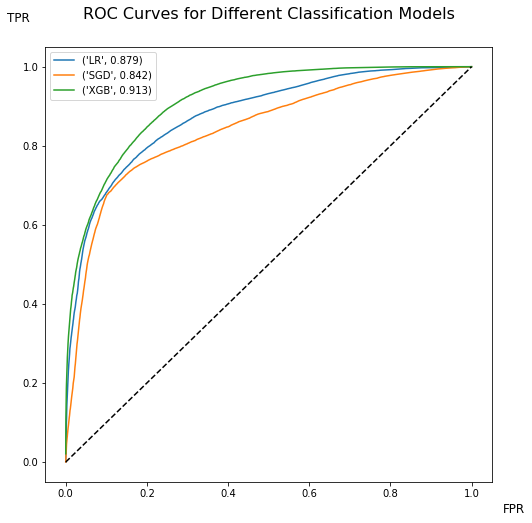

In [128]:
lr = LogisticRegression(C = 100000, max_iter = 10000, random_state = 42,
                        solver ='saga', class_weight = 'balanced')

sgd = SGDClassifier(max_iter = 10000, random_state = 42, alpha = 0.001,
                    loss = 'log', class_weight = 'balanced', 
                    learning_rate = 'adaptive', eta0 = 0.001)

xgb = XGBClassifier(random_state = 42, learning_rate = 0.1, max_depth = 3, 
                    n_estimators = 500, class_weight = 'balanced')

classifiers = {'LR': lr, 
               'SGD': sgd,
               'XGB': xgb}

fpr, tpr, thresholds, roc_auc = plot_roc_curves(classifiers,  
                                                X_train.drop(columns = dropped_cols), 
                                                y_train, 
                                                X_test.drop(columns = dropped_cols), 
                                                y_test)

Previously, we used the roc-auc score to select the best model. <br>
However, the metric of interest is actually the F2 score. <br>
The F2 score was chosen as the metric since both false positives and false negatives matter, but false negatives are more costly. <br>

A false positive is campaign that was predicted to succeed, but failed. <br>
False positives are costly for Kickstarter project teams since setting up a campaign can be costly in terms of time and resources. <br>
A failed campaign can also reflect poorly on the reputation of the respective Kickstarter project team. <br>

A false negative is a campaign that was predicted to failed, but would have succeeded. <br>
False negatives are costly for Kickstarter project teams because their goals are never actualized without the funds. <br>
It also affects Kickstarter since Kickstarter receives 10% of all donated project funds. <br>

I created this custom function to help identify the best model threshold for obtaining the best F2 score. <br>
Sometimes, models can vary in performance for reasons like receiving a different portion of the data.
The function below helps account for this by finding the best threshold across a number of trials.

In [157]:
def plot_metrics_vs_threshold(X, y, model, n_trials, beta, save_fig = False):
    """
        Helper function for plotting y_proba vs y_test
        
        :param X: data containing features
        :param y: an array of the actual class labels
        :param model: classification model
        :param n_trials: number of trials to test the model
        :param beta: beta value for fbeta score
        
        :returns uniform_thresholds: threshold values used in plot
        :returns median_metrics_dict: dictionary of median values used for the plot
    """
    try:
        model = model.set_params(n_jobs = -1)
    except:
        pass

    metrics_dict_list = [] 
    
    
    for trial in range(n_trials): 
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)     

        model.fit(X_train, y_train) 
        y_proba = model.predict_proba(X_test)[:,1] 

        precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
        
        #append 1 since thresholds does not end with 1
        thresholds = np.append(thresholds, 1)

        metrics_dict = {'Precision': precision,
                        'Recall': recall,
                        'Queue Rate': [], 
                        'F' + str(beta): [],
                        'Thresholds': thresholds}
        

        for idx, threshold in enumerate(thresholds):
            #checking to see if each predict probability is above a threshold
            #if it is, the probability is 1 because the boolean statement evaluates to True
            #otherwise, the probability is 0 because the boolean statement evaluates to False
            #taking the mean of the final array of 0's and 1's gives the queue rate
            #the queue rate is how many cases 
            queue_rate = (y_proba >= threshold).mean()
            metrics_dict['Queue Rate'].append(queue_rate)
            
            #calculating the values for fbeta manually
            fbeta_numerator = (1 + beta**2)*precision[idx]*recall[idx]
            fbeta_denominator = (beta**2)*precision[idx] + recall[idx]

            fbeta = fbeta_numerator/fbeta_denominator

            metrics_dict['F' + str(beta)].append(fbeta)

        metrics_dict_list.append(metrics_dict)


    
    #create an array of uniform threshold values 
    #from 0 to 1, stepsize = 0.001
    uniform_thresholds = np.linspace(0, 1, 1001)

    uniform_metric_dict_list = {'Precision': [],
                                'Recall': [],
                                'Queue Rate': [], 
                                'F' + str(beta): []}

    for metrics_dict in metrics_dict_list: 

        #create a uniform_metrics_dict for each metrics_dict
        uniform_metrics_dict = {'Precision': [],
                                'Recall': [],
                                'Queue Rate': [], 
                                'F' + str(beta): []}

        for threshold in uniform_thresholds: 
            #bisect is used to find the leftmost index value in
            #metrics_dict that maps to the threshold value 
            #closest to the uniform threshold value
            idx = bisect.bisect_left(metrics_dict['Thresholds'], threshold)

            for metric_name in uniform_metrics_dict.keys():
                #obtain the metric score at the leftmost index where the 
                #threshold value in metrics_dict is closest 
                #to the uniform threshold value
                score = metrics_dict[metric_name][idx]
                uniform_metrics_dict[metric_name].append(score)

        #save the scores of each uniform_metric_dict
        #to uniform_dict_list
        for metric_name in uniform_metrics_dict.keys():
            scores = uniform_metrics_dict[metric_name]
            uniform_metric_dict_list[metric_name].append(scores)


    quantiles = [0.1, 0.5, 0.9]
    
    median_metrics_dict = {'Precision': [],
                           'Recall': [],
                           'Queue Rate': [],
                           'F' + str(beta): []}
    
    plt.figure(figsize = (8,8), dpi= 80)

    for idx, (metric_name, scores) in enumerate(uniform_metric_dict_list.items()):

        #bin the scores of each metric into lower, median, and upper quartiles
        lower_scores, median_scores, upper_scores = mstats.mquantiles(scores, quantiles, axis = 0)

        #plot the median score
        plt.plot(uniform_thresholds, median_scores)

        #indicate range of values
        plt.fill_between(uniform_thresholds, upper_scores, lower_scores, 
                         alpha = 0.5, linewidth = 0, color=sns.color_palette()[idx]) 
        
        median_metrics_dict[metric_name] = median_scores 

    plt.legend(('Precision', 'Recall', 'Queue Rate', 'F' + str(beta))) 

    plt.xlabel(xlabel = 'Threshold Value', size = 12, x = 1.05)
    plt.ylabel(ylabel = 'Metric Score', size = 12, rotation = 0, y = 1.01)

    plt.title('Different Metrics Across Thresholds', fontsize = 16, y = 1.05)
    
        
    if save_fig:
        plt.savefig("./img/Different Metrics Across Thresholds.png")
    
    return uniform_thresholds, median_metrics_dict

The curve for F2 score follows recall closely because recall is weighted more than precision.

Logistic Regression
Best Score for F2: 0.843 	Best Threshold Value: 0.193


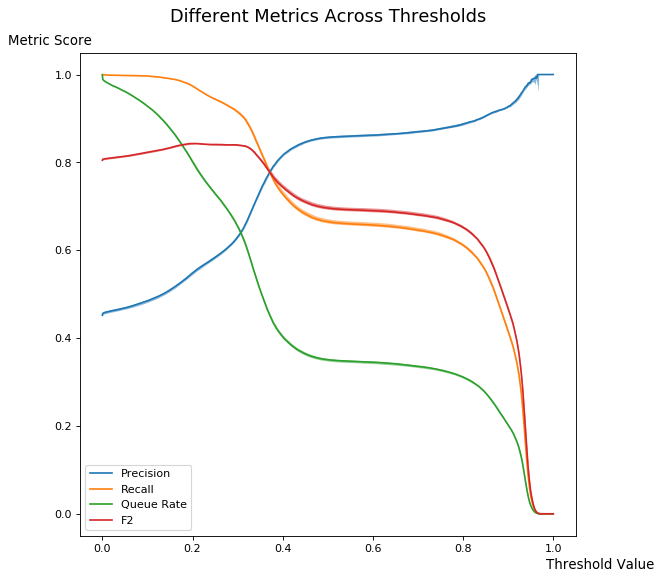

In [366]:
scaler = MinMaxScaler()
X_copy = X.drop(columns = dropped_cols)
X_copy = scaler.fit_transform(X_copy)

thresholds, lr_metrics_dict = plot_metrics_vs_threshold(X_copy, y, lr, 10, 2)

fbeta_thresholds = list(zip(lr_metrics_dict['F2'], thresholds))
fbeta_thresholds = [(round(score, 3), round(threshold, 3)) for score, threshold in fbeta_thresholds]
fbeta_thresholds = sorted(fbeta_thresholds, key = lambda x:x[0], reverse = True)
print('Logistic Regression')
print('Best Score for F2: %s \tBest Threshold Value: %s' %fbeta_thresholds[0])

invalid value encountered in double_scalars
invalid value encountered in double_scalars


KeyError: 'F1'

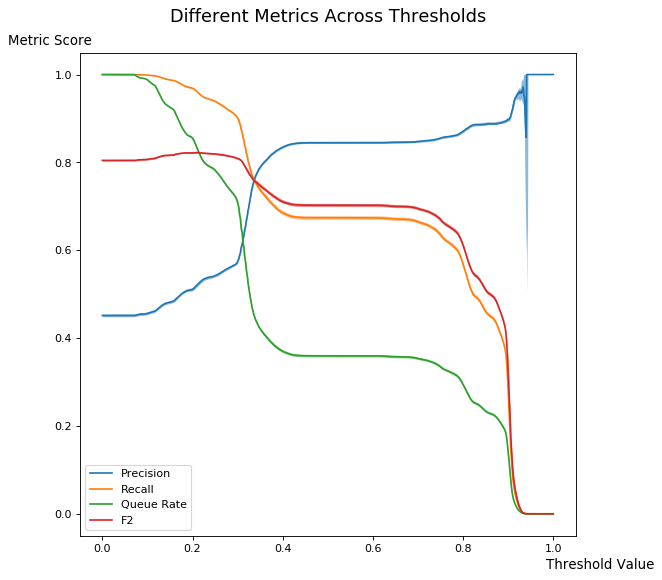

In [249]:
thresholds, sgd_metrics_dict = plot_metrics_vs_threshold(X_copy, y, sgd, 25, 2)

fbeta_thresholds = list(zip(sgd_metrics_dict['F1'], thresholds))
fbeta_thresholds = [(round(score, 3), round(threshold, 3)) for score, threshold in fbeta_thresholds]
fbeta_thresholds = sorted(fbeta_thresholds, key = lambda x:x[0], reverse = True)
print('SGDClassifier')
print('Best Score for F2: %s \tBest Threshold Value: %s' %fbeta_thresholds[0])

This last one for XGBClassifier is just for comparison.

XGBClassifier
Best Score for F2: 0.883 	Best Threshold Value: 0.141


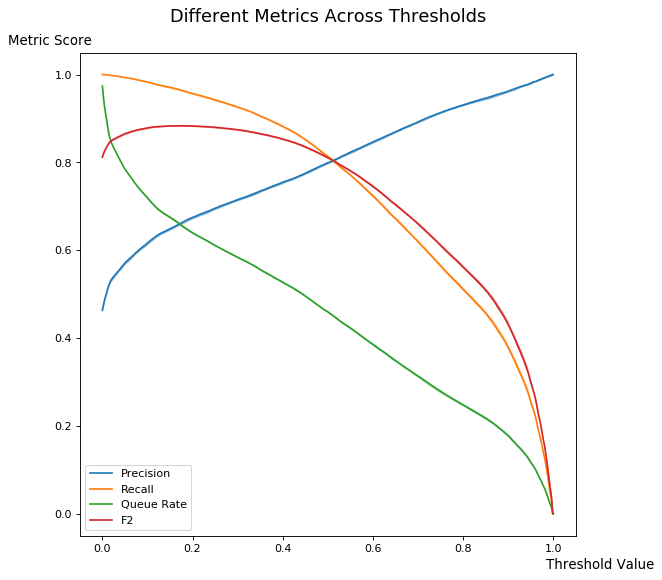

In [129]:
thresholds, xgb_metrics_dict = plot_metrics_vs_threshold(X_copy, y, xgb, 25, 2)

fbeta_thresholds = list(zip(xgb_metrics_dict['F2'], thresholds))
fbeta_thresholds = [(round(score, 3), round(threshold, 3)) for score, threshold in fbeta_thresholds]
fbeta_thresholds = sorted(fbeta_thresholds, key = lambda x:x[0], reverse = True)
print('XGBClassifier')
print('Best Score for F2: %s \tBest Threshold Value: %s' %fbeta_thresholds[0])

The difference in F2 score between logistic regression and SGDClassifier was not too large. <br>
I used SGDClassifier from this point onwards since it was quicker to train for large datasets.

In [162]:
sgd = SGDClassifier(max_iter = 10000, random_state = 42, alpha = 0.001,
                    loss = 'log', class_weight = 'balanced', 
                    learning_rate = 'adaptive', eta0 = 0.001, n_jobs = -1)

#the optimum threshold found was 0.202
threshold = 0.202

sgd.fit(X_train.drop(columns = dropped_cols), y_train)

y_proba = sgd.predict_proba(X_test.drop(columns = dropped_cols))[:,1]

#anything above or equal to the threshold is 1
#anything below the threshold is 0
y_pred = (y_proba >= threshold)

f2_score = fbeta_score(y_test, y_pred, 2)
print('F2 Score: %s' %round(f2_score, 3))

F2 Score: 0.823


Return to [Table of Contents](#table)

## 9. SHAP for Model Interpretability <a name="shap"></a>

Now that we have selected a model and threshold i.e. SGDClassifier with a threshold of 0.178, we can look further into SHAP. <br>
Previously, SHAP was used to understand the impact of each feature on model performance. <br>
SHAP can also be used to generate a force plot that allows us to understand how each feature affects the class probability of a prediction. <br>
This can be particularly useful for making recommendations for each prediction.

In [163]:
sgd = SGDClassifier(max_iter = 10000, random_state = 42, alpha = 0.001,
                    loss = 'log', class_weight = 'balanced', 
                    learning_rate = 'adaptive', eta0 = 0.001, n_jobs = -1)

#the optimum threshold found was 0.202
threshold = 0.202

sgd.fit(X_train.drop(columns = dropped_cols), y_train)

y_proba = sgd.predict_proba(X_test.drop(columns = dropped_cols))[:,1]

#anything above or equal to the threshold is True
#anything below the threshold is False
y_pred = (y_proba >= threshold)

Accuracy: 0.57
Precision: 0.512
Recall: 0.97
F2: 0.823


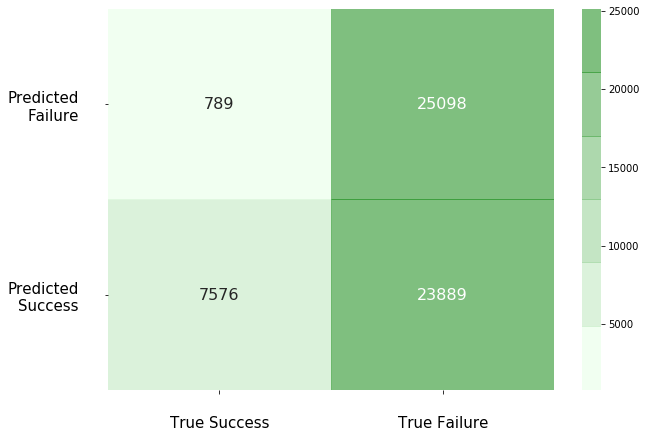

In [164]:
y_pred_renamed = np.array([1 if pred else 0 for pred in y_pred])

cm = confusion_matrix(y_test, y_pred_renamed, labels=[0, 1])

df_cm = pd.DataFrame(cm, index = ['Predicted\nSuccess', 'Predicted\nFailure'], 
                         columns = ['True Success', 'True Failure'])

plt.figure(figsize=(10,7))
cm_plot = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', 
                      cmap=sns.light_palette("green"), alpha = 0.5)

#set y limits for axis so plot displays correctly
cm_plot = cm_plot.set_ylim([0,2])
plt.yticks(rotation = 0, fontsize = 15, x= -0.05);
plt.xticks(fontsize = 15, y =-.05);

print('Accuracy: %s' %round(accuracy_score(y_test, y_pred_renamed), 3))
print('Precision: %s' %round(precision_score(y_test, y_pred_renamed), 3))
print('Recall: %s' %round(recall_score(y_test, y_pred_renamed), 3))
print('F2: %s' %round(fbeta_score(y_test, y_pred_renamed, beta = 2), 3))

In [348]:
explainer = shap.LinearExplainer(sgd, X_train.drop(columns = dropped_cols), 
                                 feature_perturbation = "interventional")

#shap_values is a matrix of the feature weights for each observation
#it is an observation x features matrix
shap_values = explainer.shap_values(X_test.drop(columns = dropped_cols))

#a dense array is needed for SHAP
X_test_dense = scipy.sparse.csr_matrix(X_test.drop(columns = dropped_cols).values).toarray()

In [364]:
def SHAP_force_plot(explainer, shap_values, X_test_dense, y_pred, y_test, idx):
    """
        Helper function for plotting force plots from SHAP
        
        :param explainer: explainer produced by SHAP
        :param shap_values: a matrix of the feature weights for each 
                            observation produced by explainer.shap_values
        :param X_test_dense: a dense matrix of the test values
        :param y_pred: an array of the predicted class labels
        :param y_test: an array of the actual class labels
        :param idx: index at which to index X_test_dense
    """

    print('Predicted Class Probability: %s' %(round(y_proba[idx], 3)))

    predicted_class = 'Success' if y_pred[idx] else 'Fail'
    actual_class = 'Success' if y_test.values[idx] else 'Fail'

    print('Predicted Class Label: %s \t\tActual Class Label: %s' %(predicted_class, actual_class))
    
    #explainer.expected_value is the difference between the predicted SHAP label and actual label
    #use logit in order to get probabibiltiies instead of log odds
    #matplotlib = True generates a less graphic intensive plot

    
    shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test_dense[idx,:],
                feature_names = X_test.drop(columns = dropped_cols).columns, 
                link = 'logit', matplotlib = True, text_rotation = 30);
    

Intuitively, we would think a class probability greater than 0.5 is a success. <br>
The base value for probability is also quite close to 0.5. <br>
Yet, class probabilities as low as 0.252 are still considered successes. <br>
This is because our model threshold is 0.178, so any observation with class probability greater or equal to this value is considered a success. <br>
The model is not perfect as there will some predictions that are wrong, as shown in the third plot. <br>

Unintutively, the red arrow in the SHAP plot indicate factors that increase the chance of a campaign succeeding. <br>
The blue arrows in the SHAP plot indicate factors that increase the chance of a campaign failing. <br>
The larger the arrow of a factor, the more important that factor is in determining the outcome of the prediction.

Predicted Class Probability: 0.252
Predicted Class Label: Success 		Actual Class Label: Success


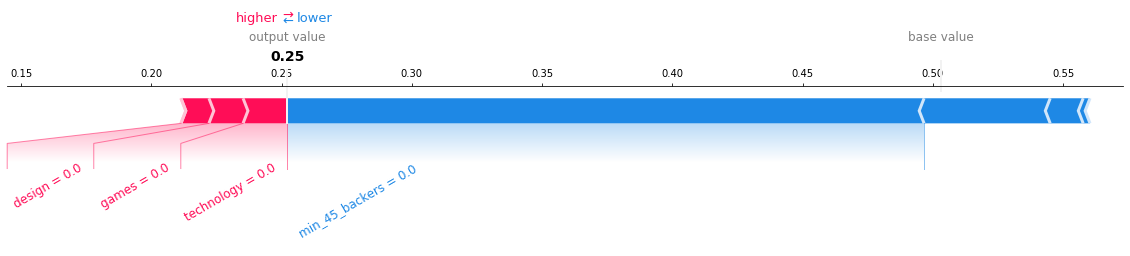

Predicted Class Probability: 0.13
Predicted Class Label: Fail 		Actual Class Label: Fail


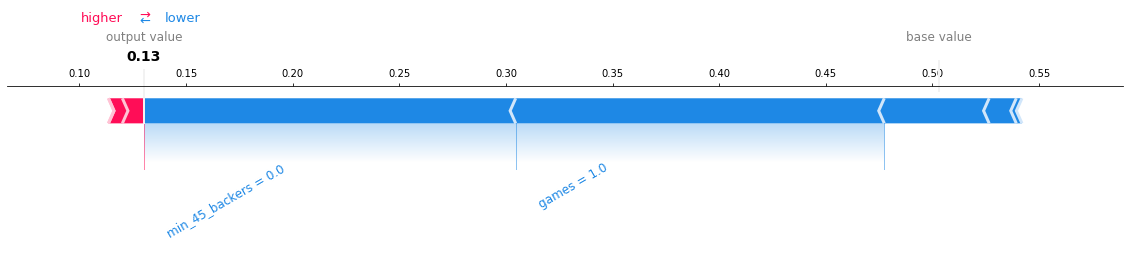

Predicted Class Probability: 0.27
Predicted Class Label: Success 		Actual Class Label: Fail


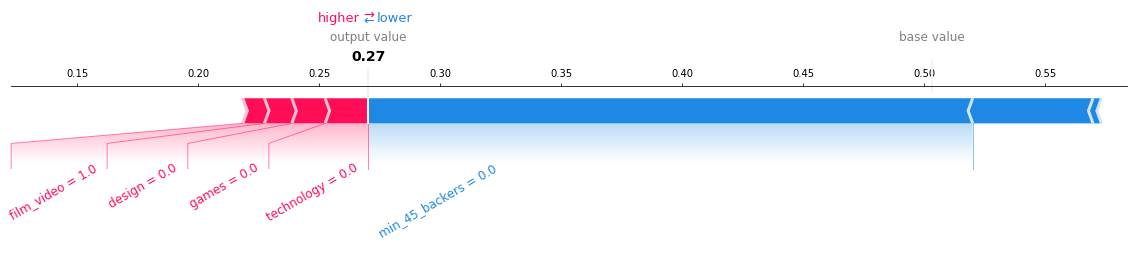

In [365]:
SHAP_force_plot(explainer, shap_values, X_test_dense, y_pred, y_test, 5)
SHAP_force_plot(explainer, shap_values, X_test_dense, y_pred, y_test, 1)
SHAP_force_plot(explainer, shap_values, X_test_dense, y_pred, y_test, 10)

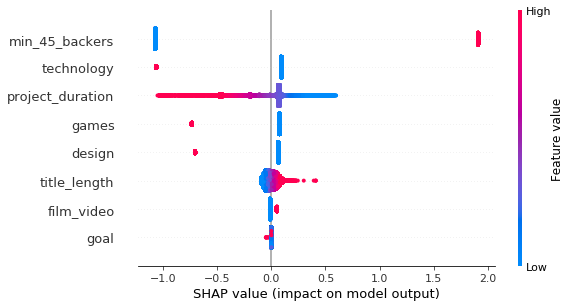

In [359]:
shap.summary_plot(shap_values, X_test_dense, 
                  feature_names =  X_test.drop(columns = dropped_cols).columns)

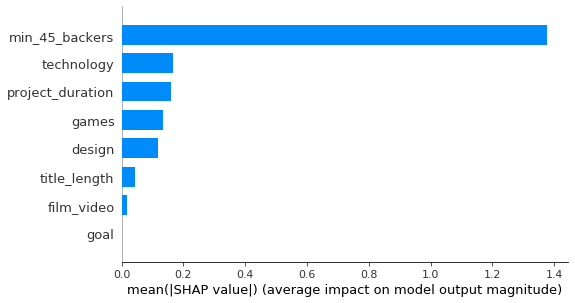

In [361]:
shap.summary_plot(shap_values, X_test_dense, 
                  feature_names =  X_test.drop(columns = dropped_cols).columns, plot_type = 'bar')

Return to [Table of Contents](#table)

## 10. Save Model <a name="save"></a>

In [167]:
dropped_cols = ['theater', 'US', 'min_30_days', 'journalism', 
                'crafts', 'comics', 'photography', 'art', 
                'music', 'fashion', 'food', 'publishing']

Saving the data and scaler for use later in deployment on Flask.

In [168]:
ks2018 = ks2018.drop(columns = dropped_cols)
X, y = ks2018.drop('successful', axis = 1), ks2018['successful']
columns = X.columns

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X = pd.DataFrame(X, columns = columns)

X

,title_length,min_45_backers,goal,project_duration,design,film_video,games,technology
0,0.21875,0.0,0.000270,0.650016,0.0,1.0,0.0,0.0
1,0.06250,0.0,0.000407,0.488845,0.0,1.0,0.0,0.0
2,0.18750,0.0,0.000044,0.324192,0.0,0.0,0.0,0.0
3,0.06250,1.0,0.000452,0.373925,0.0,0.0,0.0,0.0
4,0.25000,0.0,0.000007,0.208510,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
286751,0.15625,0.0,0.000057,0.315704,0.0,0.0,0.0,0.0
286752,0.03125,0.0,0.000012,0.291435,0.0,1.0,0.0,0.0
286753,0.31250,0.0,0.000134,0.490913,0.0,1.0,0.0,0.0
286754,0.06250,0.0,0.000134,0.328327,0.0,0.0,0.0,1.0


In [326]:
if 'model' not in os.listdir():
    os.mkdir('model')


file_dir = os.path.abspath('.')
data_folder = 'data'
path = os.path.join(file_dir, data_folder, 'ks2018_final.pkl')

ks2018 = X.join(pd.DataFrame(y), on = y.index)

ks2018.to_pickle(path)

#saving the scaler
model_folder = 'model'
path = os.path.join(file_dir, model_folder, 'scaler.pkl')

pickle.dump(scaler, open(path, 'wb'))

Training the model and saving it for use in deployment on Flask.

In [169]:
sgd = SGDClassifier(max_iter = 10000, random_state = 42, alpha = 0.001,
                    loss = 'log', class_weight = 'balanced', 
                    learning_rate = 'adaptive', eta0 = 0.001, n_jobs = -1)


sgd.fit(X, y)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='log',
              max_iter=10000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [328]:
file_dir = os.path.abspath('.')
data_folder = 'model'
path = os.path.join(file_dir, data_folder, 'sgd_classifier.pkl')

pickle.dump(sgd, open(path, 'wb'))

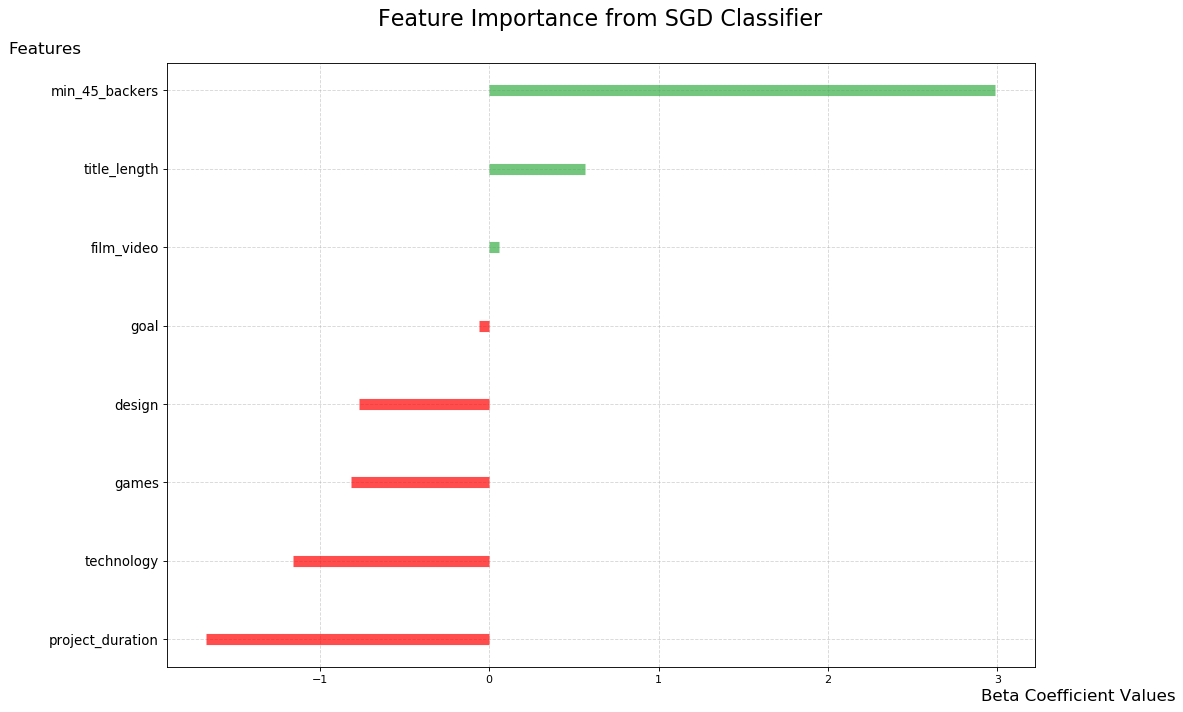

In [170]:
sgd_feature_df = pd.DataFrame.from_dict({'Features': X.columns, 
                                         'Coefs': sgd.coef_[0]})

sgd_feature_df['Colors'] = sgd_feature_df['Coefs'].apply(lambda coef: 'red' 
                                                          if coef < 0 else sns.xkcd_rgb["medium green"])

sgd_feature_df = sgd_feature_df.sort_values('Coefs', ascending = True).reset_index(drop = True)



plt.figure(figsize=(14,10), dpi= 80)
plt.hlines(y = sgd_feature_df.index, xmin = 0, xmax = sgd_feature_df['Coefs'], 
           color = sgd_feature_df['Colors'], alpha=0.7, linewidth=10)

plt.xlabel(xlabel = 'Beta Coefficient Values', size = 15, x = 1.05)
plt.ylabel(ylabel = 'Features', size = 15, rotation = 0, y = 1.01)

plt.yticks(sgd_feature_df.index, sgd_feature_df['Features'], fontsize=12)
plt.title('Feature Importance from SGD Classifier', fontsize=20, y = 1.05)
plt.grid(linestyle='--', alpha=0.5)

plt.savefig("./img/Feature Importance from SGDClassifier.png", bbox_inches='tight')

This is how to interpret the beta coefficients from SGD classifier. <br>
Unlike linear regression, notice that we do not have to undo the scaling from `MinMaxScaler`. <br>
This is because every value will be in terms of probabilities or odds in the end - therefore, unitless. <br>
The probabilities can be misleading because you have to consider the interactions between terms, base conditions, and intercept. <br>
Generally, for every one unit increase in a feature, the probability of the target variable being a certain class increases by that much. <br>

In [248]:
log_odds = sgd.coef_[0]
odds = np.exp(log_odds)
probs = [round(odd/(odd+1), 3) for odd in odds]
sgd_coefs = pd.DataFrame.from_dict({'Log Odds':log_odds, 
                                    'Odds': odds, 
                                    'Probabilities':probs})

intercept_odds = np.exp(sgd.intercept_)
intercept_probs = (intercept_odds/(intercept_odds + 1))[0]
intercept_probs = round(intercept_probs, 3)
print('Base Value: %s' %intercept_probs)

sgd_coefs.index = X.columns
sgd_coefs

Base Value: 0.421


,Log Odds,Odds,Probabilities
title_length,0.568381,1.765407,0.638
min_45_backers,2.986571,19.817609,0.952
goal,-0.058324,0.943344,0.485
project_duration,-1.670124,0.188224,0.158
design,-0.768595,0.463664,0.317
film_video,0.059473,1.061277,0.515
games,-0.816589,0.441937,0.306
technology,-1.157221,0.314359,0.239


The threshold might change with more data so it is helpful to check again after training on all the data. <br>

invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in double_scalars
invalid value encountered in dou

SGDClassifier
Best Score for F2: 0.823 	Best Threshold Value: 0.209


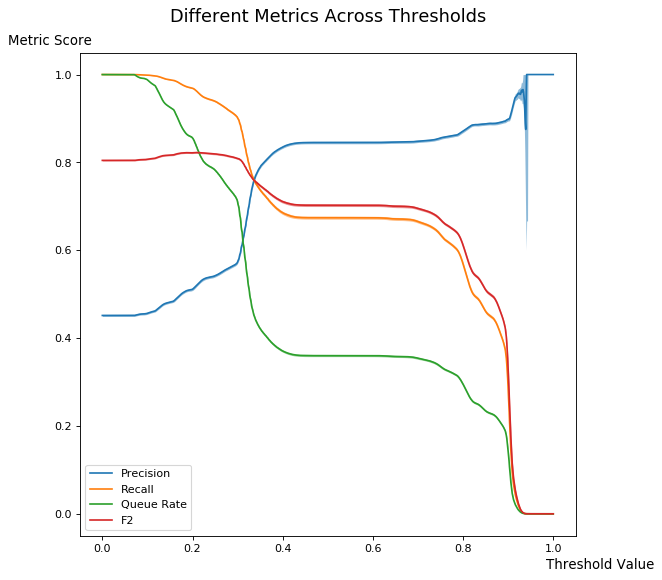

In [253]:
thresholds, sgd_metrics_dict = plot_metrics_vs_threshold(X, y, sgd, 500, 2, 
                                                         save_fig = True)

fbeta_thresholds = list(zip(sgd_metrics_dict['F2'], thresholds))
fbeta_thresholds = [(round(score, 3), round(threshold, 3)) for score, threshold in fbeta_thresholds]
fbeta_thresholds = sorted(fbeta_thresholds, key = lambda x:x[0], reverse = True)
print('SGDClassifier')
print('Best Score for F2: %s \tBest Threshold Value: %s' %fbeta_thresholds[0])

Save the explainer as well for making recommendations.

In [252]:
explainer = shap.LinearExplainer(sgd, ks2018.drop('successful', axis = 1), 
                                 feature_perturbation = "interventional")

file_dir = os.path.abspath('.')
data_folder = 'model'
path = os.path.join(file_dir, data_folder, 'sgd_explainer.pkl')

pickle.dump(explainer, open(path, 'wb'))

Return to [Table of Contents](#table)